# I210503 Muhammad Zian Ahmed CS-A
# I210872 Muti Ur Rehman CS-B

In [1]:
import tensorflow as tf
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2



from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tabulate import tabulate

# Source Path
#### Update Here

In [2]:
src = 'C:/Projects/Python/DIP/DIP/'

# Loading Images

In [3]:


# Load image paths
directorym = f'{src}resizedo/*.png'
file_pathsm = tf.io.gfile.glob(directorym)
file_pathsm.sort()
directorys = f'{src}resized/*.png'
file_pathss = tf.io.gfile.glob(directorys)
file_pathss.sort()

mask = tf.data.Dataset.from_tensor_slices(file_pathsm)
mask = mask.map(lambda x: tf.io.read_file(x))
mask = mask.map(lambda x: tf.image.decode_png(x))
mask=  mask.map(lambda x: tf.image.rgb_to_grayscale(x))
mask = mask.map(lambda x: tf.where(x > 127, 1, 0))


mask2 = tf.data.Dataset.from_tensor_slices(file_pathsm)
mask2 = mask2.map(lambda x: tf.io.read_file(x))
mask2 = mask2.map(lambda x: tf.image.decode_png(x))
mask2=  mask2.map(lambda x: tf.image.rgb_to_grayscale(x))
mask2 = mask2.map(lambda x: tf.where(x>240, 1, 0))



# Load images
data = tf.data.Dataset.from_tensor_slices(file_pathss)
data = data.map(lambda x: tf.io.read_file(x))
data = data.map(lambda x: tf.image.decode_png(x))
data =  data.map(lambda x: tf.image.rgb_to_grayscale(x))


# Convert the dataset to a list
image_list = list(data.as_numpy_iterator())
mask_list =  list(mask.as_numpy_iterator())
mask_list2 =  list(mask2.as_numpy_iterator())

image_array = np.array(image_list)
mask_cup = np.array(mask_list)
mask_disk = np.array(mask_list2)




# Preprocessing
##### Blurring the Image using kernel (9,9)

In [4]:
for image in image_array:
    image = cv2.GaussianBlur(image, (9, 9), 0)
    break

# Encoder Block

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x) 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p 

# Decoder 



In [7]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


# UNET MODEL

In [10]:

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary

    model = Model(inputs, outputs, name="U-Net")
    return model


# Training Model
### Using first 20 images to train Model
### Retrain Model

In [11]:
# # Build the model
# modelcup = build_unet((256,256,1))
# modeldisk = build_unet((256,256,1))


# # Compile the model
# modelcup.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])
# modeldisk.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# cuphistory = modelcup.fit(image_array[:20,:,:,:], mask_cup[:20,:,:,:], batch_size=2, epochs=30, validation_split=0.2)
# dischistory = modeldisk.fit(image_array[:20,:,:,:], mask_disk[:20,:,:,:], batch_size=2, epochs=30, validation_split=0.2)

#### Loading Weights from Pre Trained Model
##### Images Used: 20
##### Epochs:      50

In [12]:
modelcup  = load_model(f'{src}od.keras')
modeldisk = load_model(f'{src}oc.keras')

# Prediction
Change Value of i to test Image Num

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


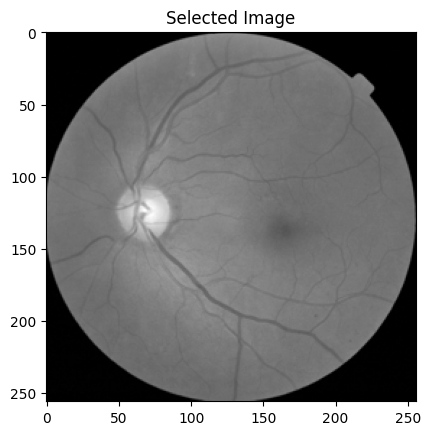

In [18]:
idx = 22 # here you can change the index of the image you want to predict
p1 = modelcup.predict(image_array[idx-1:idx,:,:,:])
p2 = modeldisk.predict(image_array[idx-1:idx,:,:,:])
# Probability threshold


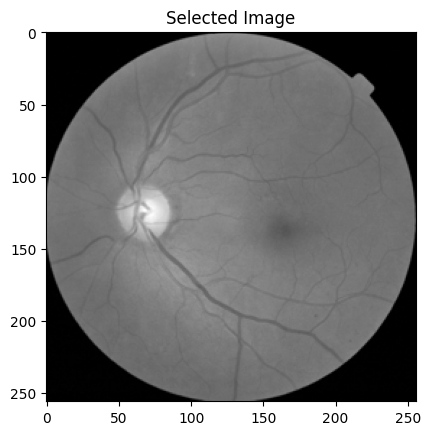

In [30]:
predicted_cup = np.where(p1 > 0.93, 1, 0)
predicted_disk = np.where(p2 > 0.1, 1, 0)

#Display Selected Images
plt.imshow(image_array[idx-1],cmap='gray')
plt.title("Selected Image")
plt.show()

# Metrics Calculation

In [14]:
def calculate_metrics(true_masks, predicted_masks):
    # True positives, false positives, false negatives
    tp = np.sum(np.logical_and(true_masks, predicted_masks))
    fp = np.sum(np.logical_and(1 - true_masks, predicted_masks))
    fn = np.sum(np.logical_and(true_masks, 1 - predicted_masks))
    tn = np.sum(np.logical_and(1 - true_masks, 1 - predicted_masks))
    # Accuracy
    accuracy = (tp + np.sum(1 - true_masks)) / (tp + fp + fn + np.sum(1 - true_masks))
    
    # Precision
    precision = tp / (tp + fp)
    
    # Recall
    recall = tp / (tp + fn)
    
    # Intersection over Union (IoU)
    iou = tp / (tp + fp + fn)
    
    return accuracy, precision, recall, iou

# Diagnosis Using CDR 

In [15]:
def diagnose(oc,od):

    OD_area = np.sum(oc)  # Area of segmented optic disc
    OC_area = np.sum(od)  # Area of segmented optic cup

    # Calculate Cup-to-Disc Ratio (CDR)
    CDR = OC_area / OD_area
    
    if CDR > 0.4:  
        return CDR,"High likelihood of glaucoma"
    else:
        return CDR,"Low likelihood of glaucoma"

# FINAL DIAGNOSIS AND MODEL METRICS

In [22]:
# Calculate evaluation metrics for disk segmentation
accuracy_disc, precision_disc, recall_disc, iou_disc = calculate_metrics(mask_cup[idx-1], predicted_cup[0])

# Calculate evaluation metrics for cup segmentation
accuracy_cup, precision_cup, recall_cup, iou_cup = calculate_metrics(mask_disk[idx-1], predicted_disk[0] )
CDR,diagnosis = diagnose(predicted_disk[0],predicted_cup[0])


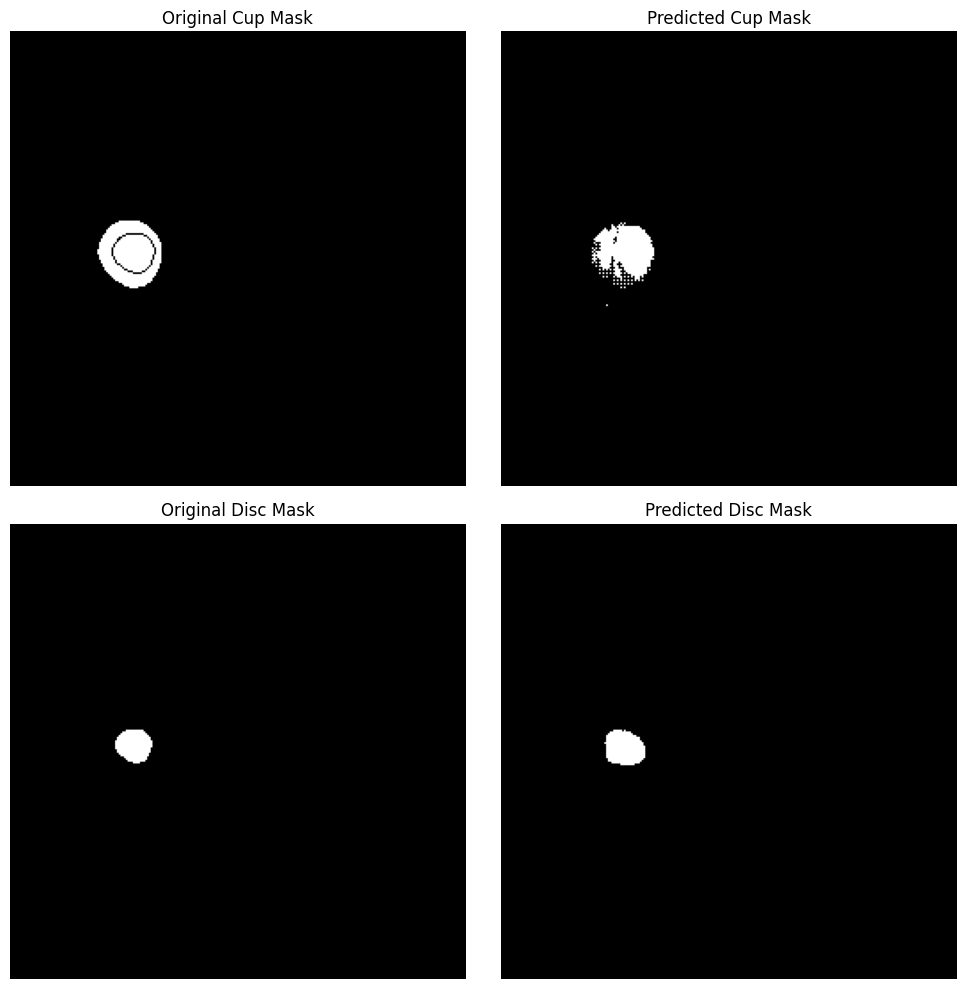

In [31]:
data = [
    ["Optic Disc Segmentation", "Accuracy", accuracy_disc],
    ["", "Precision", precision_disc],
    ["", "Recall", recall_disc],
    ["", "IoU", iou_disc],
    ["Optic Cup Segmentation", "Accuracy", accuracy_cup],
    ["", "Precision", precision_cup],
    ["", "Recall", recall_cup],
    ["", "IoU", iou_cup],
    ["Diagnosis", "CDR", CDR],
    ["", "Diagnosis", diagnosis]
]

table = tabulate(data, headers=["Segmentation Task", "Metric", "Value"])

print(table)

plt.figure(figsize=(10, 10))  # Set the overall figure size

# Display images
plt.subplot(2, 2, 1)
plt.imshow(mask_cup[idx-1], cmap='gray')
plt.title('Original Cup Mask')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(predicted_cup[0], cmap='gray')
plt.title('Predicted Cup Mask')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mask_disk[idx-1], cmap='gray')
plt.title('Original Disc Mask')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(predicted_disk[0], cmap='gray')
plt.title('Predicted Disc Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluations Metrics

In [32]:
from tabulate import tabulate

Segmentation Task        Metric     Value
-----------------------  ---------  ---------------------------
Optic Disc Segmentation  Accuracy   0.9719950727950015
                         Precision  0.3375224416517056
                         Recall     0.9572301425661914
                         IoU        0.33250795896710295
Optic Cup Segmentation   Accuracy   0.996368408203125
                         Precision  1.0
                         Recall     0.2247557003257329
                         IoU        0.2247557003257329
Diagnosis                CDR        40.36231884057971
                         Diagnosis  High likelihood of glaucoma
